Animal_Emotion_Detection

**Importing The Modules**

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# Replace the original import statement with this one
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

**Data Loading and Preprocessing**

In [2]:
# Define the path to the dataset folders
happy_folder = "/kaggle/input/pets-facial-expression-dataset/happy"
sad_folder = "/kaggle/input/pets-facial-expression-dataset/Sad"
angry_folder = "/kaggle/input/pets-facial-expression-dataset/Angry"


# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

# Load images and labels for each emotion
happy_images = load_images_from_folder("happy")
sad_images = load_images_from_folder("sad")
angry_images = load_images_from_folder("angry")


# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)


# Concatenate images and labels
X = np.array(happy_images + sad_images + angry_images)
y = np.array(happy_labels + sad_labels + angry_labels)

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = to_categorical(y, 3)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Training and Evaluation**

In [3]:
# Build the CNN model
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

print(model.summary())
# Compile the model with class weights
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

In [4]:
# Calculate class weights
total_samples = len(y_train)
class_weights = {0: total_samples / np.sum(y_train[:, 0]), 
                 1: total_samples / np.sum(y_train[:, 1]), 
                 2: total_samples / np.sum(y_train[:, 2])}
# Train the model with class weights
history = model.fit(X_train.reshape(-1, 48, 48, 1), y_train, batch_size=32, epochs=100, validation_split=0.1, class_weight=class_weights,verbose=0)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test.reshape(-1, 48, 48, 1), y_test)
losstr, accuracytr = model.evaluate(X_train.reshape(-1, 48, 48, 1), y_train)


# Save the trained model
model.save("facial_expression_model.h5")

19/19 [==============================] - 1s 70ms/step - loss: 0.3339 - accuracy: 0.9467


c:\users\hargun kaur\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Train accuracy: {accuracytr*100:.2f}%")

Test accuracy: 66.67%
Train accuracy: 94.67%


**Hyperparamter tuning**

**Testing the model on Pet's images**

1/1 [==============================] - 0s 95ms/step
Predicted Emotion: angry
Confidence [happy, sad, angry]: [1.2404849e-10 3.0874227e-11 1.0000000e+00]


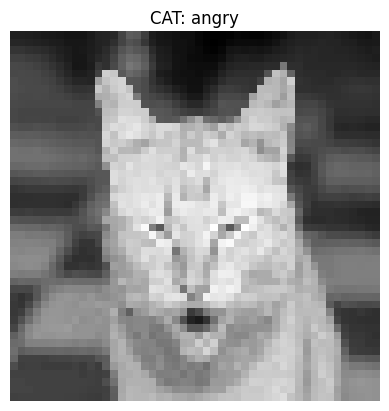

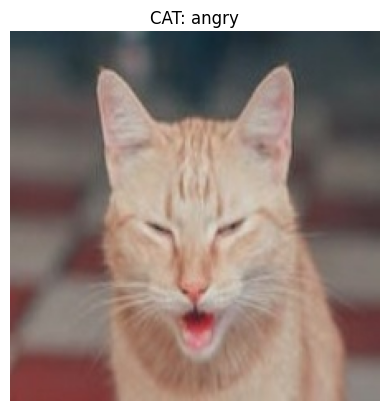

In [21]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Load the saved model
loaded_model = load_model("facial_expression_model.h5")

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Error: Could not load image from {image_path}")

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize the image
    img = cv2.resize(img, (48, 48))
    
    # Normalize the image
    img = img.astype('float32') / 255.0
    
    # Add channel dimension (for grayscale image)
    img = np.expand_dims(img, axis=-1)
    
    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    
    return img

# Load and preprocess the custom test image
custom_test_image_path = "C:/Users/hargun kaur/OneDrive/Desktop/Animal_Emotion_Detection/Angry/02.jpg"
custom_test_image = load_and_preprocess_image(custom_test_image_path)

# Make a single prediction on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
emotion_label = np.argmax(prediction_prob)
predicted_emotion = emotion_classes.get(emotion_label, "unknown")

# Print the predicted emotion and its confidence
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

# Display the preprocessed custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0], cmap='gray')
plt.title(f"CAT: {predicted_emotion}")
plt.axis('off')
plt.show()

# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"CAT: {predicted_emotion}")
plt.axis('off')
plt.show()
